# Analysing Current Data from a Nortek Vector ADV

This notebook presents a structured workflow for analysing current velocity data collected from a Nortek Vector Acoustic Doppler Velocimeter (ADV), widely used in coastal and oceanographic research to examine water movement and turbulence. In this notebook, we will:

1. **Load and Inspect Raw Data**: Start by loading the raw data from the Nortek Vector device to familiarise ourselves with the data structure and contents.
2. **Data Cleaning and Processing**: Utilise the `Dolfyn` package to clean and process the data, removing noise and correcting errors for accurate analysis.
3. **Visualise Current Velocity Data**: Create time-series plots to visualise changes in current velocity over the data collection period.
4. **Calculate Flow Velocities at Tidal Phases**: Compute the flow velocities specifically during low and high tides to explore how tidal phases influence current strength and direction.
5. **Mean Flow Rate Analysis**: Calculate and visualise the mean flow velocities, offering insights into the overall current patterns in the study area.
6. **Spectral and Turbulence Analysis**: Perform spectral analysis and calculate turbulence statistics to understand the energy distribution across frequencies and the turbulent nature of the flow.
7. **Polar Plot Visualisation**: Display all directional data in a polar plot to illustrate the current flow directions and magnitudes, enabling a clear, intuitive understanding of the data's spatial characteristics.

By the end of this notebook, you’ll be able to interpret current dynamics, tidal effects, and turbulence characteristics based on ADV data. This workflow provides a comprehensive foundation for understanding current behaviours in marine and coastal settings.


In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
import h5netcdf
import xarray as xr
import dolfyn as dlfn
from dolfyn.adv import api

# Step 1: **Load Raw Data**

In [3]:
files1 = ('sample_data/AVC_2204.VEC')
ds = dlfn.read(files1)


## Trim the data set
#Remove data from before and after the deployment
#From the data we can see the start times for instrument 1 (AVC) is '2022-10-06 18:21:00' to '2022-10-08 08:47:00'
ds_start = '2022-10-06 18:21:00'
ds_end = '2022-10-08 08:47:00'

ds = ds.sel(time=slice(ds_start,ds_end))

print('AVC instrument trimmed to datetimes: %s and %s' %(ds_start, ds_end))
print('Data loaded.')

Reading file sample_data/AVC_2204.VEC ...
AVC instrument trimmed to datetimes: 2022-10-06 18:21:00 and 2022-10-08 08:47:00
Data loaded.


# Step 2: **Data cleaning and processing**

Utilise the `Dolfyn` package to clean and process the ADV data, addressing potential issues such as noise and erroneous readings.


Available here:
https://dolfyn.readthedocs.io/en/latest/index.html

This runs the relevant functions of the dolfyn package. See text output.

In [4]:
#Clean up the data by removing spikes:
#Dolfyn uses a method from Goring & Nikora et al.(2002)
mask = api.clean.GN2002(ds['vel'], npt=5000)
# Replace bad datapoints via cubic spline interpolation
ds['vel'] = api.clean.clean_fill(ds['vel'], mask, npt=12, method='cubic')

print('Percent of data (AVC) containing spikes: {0:.2f}%'.format(100*mask.mean()))


## Coordinate Rotations
#If the “earth” (ENU) coordinate system is specified, DOLfYN will automatically rotate the dataset 
#through the necessary coordinate systems to get there. 
#The inplace set as true will alter the input dataset “in place”, rather than create a new dataset

#We are using "earth" and we are rotating -9.7 deg from north at One Tree Island.
### See map of True north (TN), Magnetic North (MN).
declination =-9.7 
print('Declination set to %s degrees' %(declination))
# First set the magnetic declination
dlfn.set_declination(ds, declin=declination, inplace=True) 


#Once in the true ENU frame of reference, we can calculate the principal flow direction for the velocity data and rotate it into the principal frame of reference (streamwise, cross-stream, vertical). 
#Principal flow directions are aligned with and orthogonal to the flow streamlines at the measurement location.
#First, the principal flow direction must be calculated through calc_principal_heading. As a standard for DOLfYN functions, those that begin with “calc_*” require the velocity data for input. This function is different from others in DOLfYN in that it requires place the output in an attribute called “principal_heading”, as shown below.
#Again we use rotate2 to change coordinate systems.
ds.attrs['principal_heading'] = dlfn.calc_principal_heading(ds['vel'])

# Calculate depth from pressure
dlfn.adp.clean.find_surface_from_P(ds, salinity=35)
print("Calculated depth. Instrument %s, Mean depth = %s" %(ds.deployment_name, ds.depth.mean().values))

Percent of data (AVC) containing spikes: 1.23%
Declination set to -9.7 degrees
Calculated depth. Instrument AVC_22, Mean depth = 3.5960345


## Working with xarray datasets

An **xarray Dataset** is a multi-dimensional, labeled data structure, ideal for organizing complex scientific data. <br/>
It supports efficient data manipulation and analysis, including indexing by dimension names and handling missing data. <br/>
xarray also integrates well with other scientific libraries like NumPy and Dask for large-scale computations.<br/>
read more here: https://docs.xarray.dev/en/stable/

In [5]:
ds

<xarray.Dataset>
Dimensions:              (x: 3, x*: 3, time: 1106887, dir: 3, beam: 3,
                          earth: 3, inst: 3)
Coordinates:
  * x                    (x) int32 1 2 3
  * x*                   (x*) int32 1 2 3
  * time                 (time) datetime64[ns] 2022-10-06T18:21:00.124518632 ...
  * dir                  (dir) <U1 'E' 'N' 'U'
  * beam                 (beam) int32 1 2 3
  * earth                (earth) <U1 'E' 'N' 'U'
  * inst                 (inst) <U1 'X' 'Y' 'Z'
Data variables: (12/17)
    beam2inst_orientmat  (x, x*) float64 -0.3511 -0.3433 ... -1.384 -1.359
    batt                 (time) float32 13.2 13.2 13.2 13.2 ... 11.6 11.6 11.6
    c_sound              (time) float32 1.53e+03 1.53e+03 ... 1.528e+03
    heading              (time) float32 202.2 202.2 202.3 ... 209.9 209.9 209.9
    pitch                (time) float32 27.75 27.7 27.65 ... 21.04 21.02 21.01
    roll                 (time) float32 -23.75 -23.7 -23.65 ... -19.73 -19.71
    ...                   ...
    amp                  (beam, time) uint8 101 93 99 93 93 ... 106 96 129 120
    corr                 (beam, time) uint8 92 92 82 63 77 73 ... 98 99 98 99 97
    pressure             (time) float64 4.787 4.789 4.795 ... 4.433 4.429 4.423
    orientmat            (earth, inst, time) float64 -0.3338 -0.3349 ... -0.8788
    water_density        (time) float32 1.025e+03 1.025e+03 ... 1.025e+03
    depth                (time) float32 4.76 4.762 4.768 ... 4.408 4.404 4.398
Attributes: (12/42)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    fs:                          8.0
    coord_sys:                   earth
    has_imu:                     0
    declination:                 -9.7
    declination_in_orientmat:    1
    principal_heading:           74.0106

# Step 3: **Visualise Current Velocity Data**

First we can make a plotting function:

In [6]:
def smooth_line(data, sigma = 2000):
    return gaussian_filter1d(data, sigma)


def quickplot(ncdata, var, direction = 1, smooth_tide=False):
    
    if direction == 0:
        cflow = 'red'
        direc = 'Alongshore'
        print('Veloicty in alongshore direction, East is positive, South is negative')
    if direction == 1:
        cflow = 'darkred'
        direc = 'Offshore'
        print('Veloicty in offshore direction, + is offshore, - is onshore')
    if direction == 2:
        cflow = 'orange'
        direc = 'Vertical'
        print('Veloicty in vertical direction')
        
    fig, ax = plt.subplots(figsize=(10,5))

    ax2 = ax.twinx()
    ax2.plot(ncdata.variables['time'],ncdata.variables['vel'][direction], c= cflow, label = 'Current velocity (m/s)')
    
    if smooth_tide:
        ax.plot(ncdata.variables['time'],smooth_line(ncdata.variables[var][:]), label = 'Tide (dBar)')
    else:
        ax.plot(ncdata.variables['time'],ncdata.variables[var][:], label = 'Pressure (dBar)')
    pass
  
    plt.title('%s Flow velocity and tide at %s'%(direc, ncdata.deployment_name)) 
    
    ax.legend(loc = 2)
    ax2.legend(loc = 0)
    plt.grid()
    plt.show()

Veloicty in alongshore direction, East is positive, South is negative


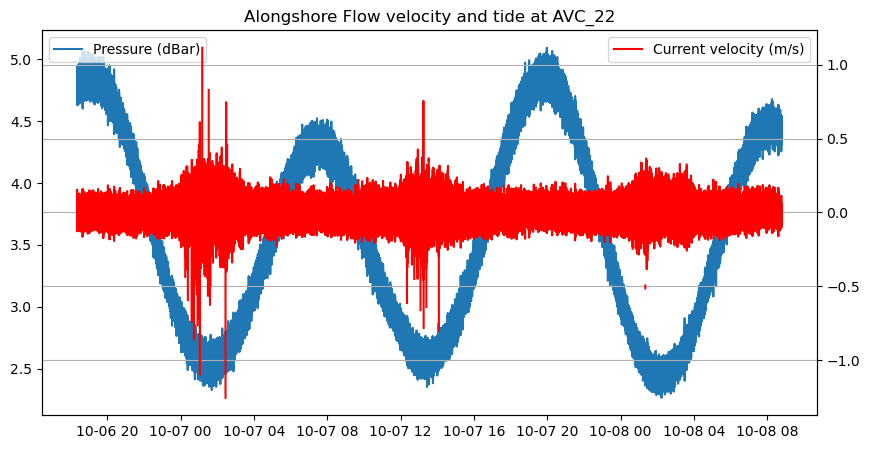

Veloicty in offshore direction, + is offshore, - is onshore


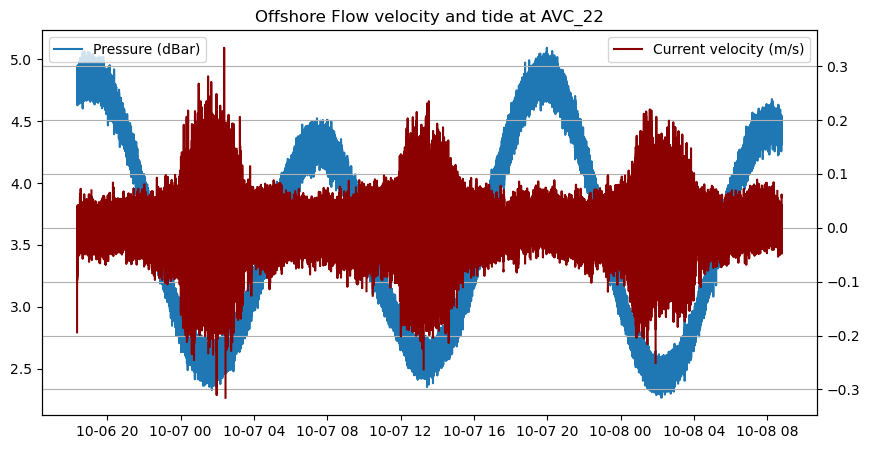

Veloicty in vertical direction


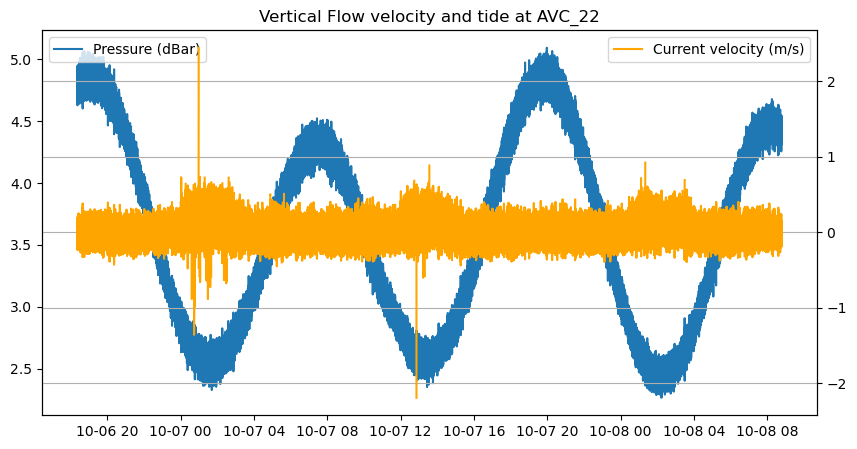

In [7]:
var = 'depth'
for direct in range (0,3):
    quickplot(ds, var, direction = direct, smooth_tide=False)


# Step 4: **Calculate Flow Velocities at Tidal Phases**

First calculate the net flow velocity

In [8]:
ds['vel_mag2D'] = np.sqrt((ds['vel'][0]*ds['vel'][0] +
                         ds['vel'][1]*ds['vel'][1]))

##Here consider flow in 3d - other direction analysis plots may condsider 2d 

ds['vel_mag3D'] = np.sqrt((ds['vel'][0]*ds['vel'][0] +
                         ds['vel'][1]*ds['vel'][1] +
                         ds['vel'][2]*ds['vel'][2]))


Then, separate tides:

In [10]:
def split_tides(ds, df_tides):
    # Filter the DataFrame to get time intervals for low tide
    low_tide_intervals = df_tides[df_tides['cat2'] == 'low']

    # Initialize an empty list to store flow rates
    low_tide_flow_rates = []

    # Iterate through the low tide intervals and select the corresponding flow rates
    for index, row in low_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the low tide interval
        low_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        low_tide_flow_rates.append(low_tide_data)

    # Merge the selected low tide flow rates into a single xarray dataset
    low_tide_flow_data = xr.concat(low_tide_flow_rates, dim='time')
    
    
        # Filter the DataFrame to get time intervals for high tide
    high_tide_intervals = df_tides[df_tides['cat2'] == 'high']

    # Initialize an empty list to store flow rates
    high_tide_flow_rates = []

    # Iterate through the high tide intervals and select the corresponding flow rates
    for index, row in high_tide_intervals.iterrows():
        start_time = row['start']
        end_time = row['end']

        # Use xarray's sel method to select flow rates within the high tide interval
        high_tide_data = ds.sel(time=slice(start_time, end_time))

        # Append the selected flow rates to the list
        high_tide_flow_rates.append(high_tide_data)

    # Merge the selected high tide flow rates into a single xarray dataset
    high_tide_flow_data = xr.concat(high_tide_flow_rates, dim='time')
    # Now, 'high_tide_flow_data' contains the flow rates at high tide intervals.
    return low_tide_flow_data, high_tide_flow_data

### Find low tide times. This was done previously and put into a df called df_intervals.

df_tides = pd.read_csv('sample_data/tidal_intervals.csv')

In [11]:

ds_low_tide, ds_high_tide = split_tides(ds, df_tides)
mean_flow_vel_high = ds_high_tide['vel_mag2D'].mean()
mean_flow_vel_low = ds_low_tide['vel_mag2D'].mean()


print('Inst A1')


# Calculate the percentage increase
percentage_increase = ((mean_flow_vel_low - mean_flow_vel_high) / mean_flow_vel_high) * 100

# Print the results
print("Mean Flow Rates:")
print(f"High Tide: {mean_flow_vel_high:.2f}")
print(f"Low Tide: {mean_flow_vel_low:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase:.2f}%")

Inst A1
Mean Flow Rates:
High Tide: 0.05
Low Tide: 0.07
Percentage Increase from High Tide to Low Tide: 57.23%


### Calculate the absolute magnitude of the flow:

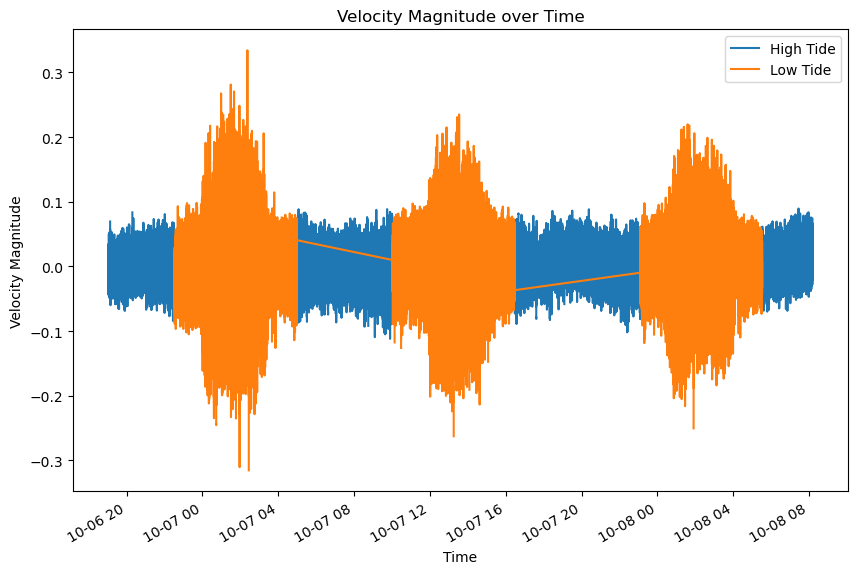

In [12]:
# Create a figure with a specific size
plt.figure(figsize=(10, 6))  # You can adjust the width (10) and height (6) as needed

# Assuming ds_high_tide and ds_low_tide are pandas Series or DataFrames
ds_high_tide['vel'][1].plot(label='High Tide')
ds_low_tide['vel'][1].plot(label='Low Tide')

# Customize the plot
plt.title('Velocity Magnitude over Time')
plt.xlabel('Time')
plt.ylabel('Velocity Magnitude (m/s)')
plt.legend()

# Display the plot
plt.show()

# Step 5: **Mean Flow Rate Analysis**

In [13]:
# Resample the data to find the max, min and mean flow velocities

ds_rsp_max = ds.resample(time="0.25H").max()
ds_rsp_mean = ds.resample(time="0.25H").mean()
ds_rsp_min = ds.resample(time="0.25H").min()

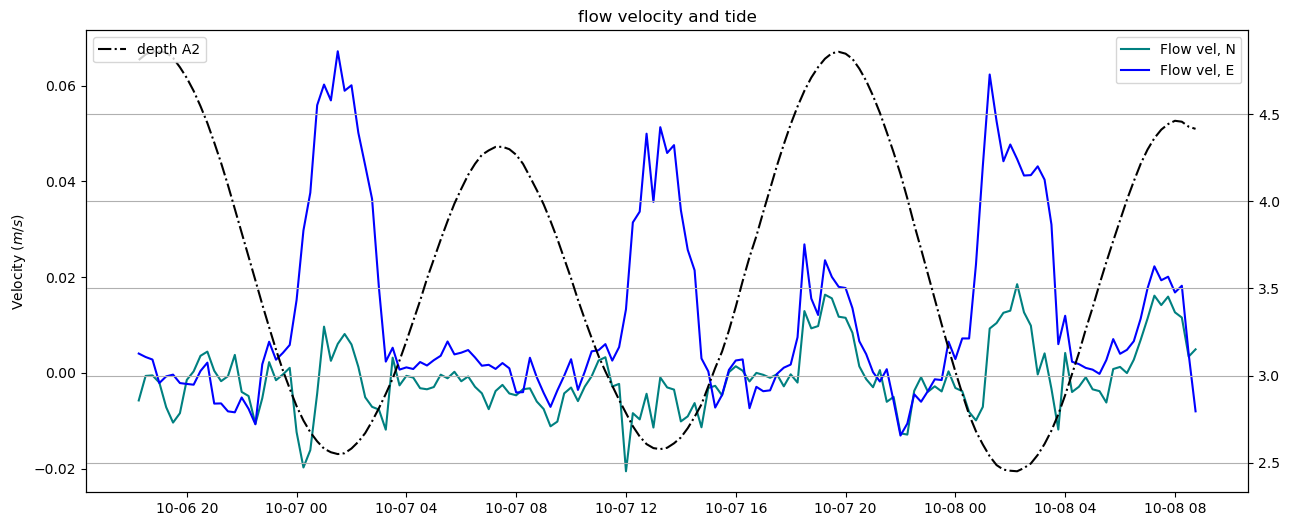

In [14]:
direction = 1
fig, ax = plt.subplots(figsize = (15,6))
ax2 = ax.twinx()
#ax.plot(ds.variables['time'],ds.variables['vel'][direction], label = 'All data', color = 'lightgrey')
#ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,direction], c ='r', label = 'max offshore')
#ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,direction], color='coral', label = 'mean flow, A1')

ax2.plot(ds_rsp_mean.time, ds_rsp_mean.depth, color='k',ls='-.', label = 'depth A2')
ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,direction], color='teal', label = 'Flow vel, N')
ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,0], color='b', label = 'Flow vel, E')
#ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,direction], color='b', label = 'max onshore')
ax.legend(loc = 1)
ax2.legend(loc = 2)
ax.set_title('flow velocity and tide')
ax.set_ylabel('Velocity $(m/s)$')
plt.grid()
#plt.savefig('max_min_%s_%s.png'%(direc, ds.deployment_name))

plt.show()


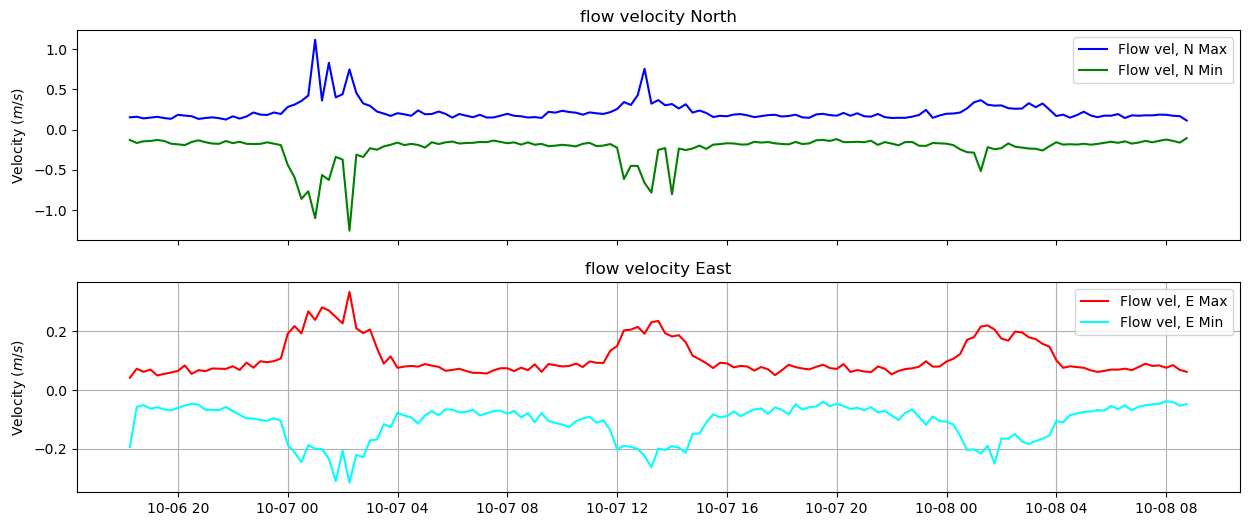

In [15]:
direction = 1
fig, ax = plt.subplots(nrows=2,ncols=1, figsize = (15,6),sharex=True)

#ax.plot(ds.variables['time'],ds.variables['vel'][direction], label = 'All data', color = 'lightgrey')
#ax.plot(ds_rsp_max.time, ds_rsp_max.vel[:,direction], c ='r', label = 'max offshore')
#ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,0], color='b', label = 'Flow vel, N Mean')
ax[0].plot(ds_rsp_max.time, ds_rsp_max.vel[:,0], color='b', label = 'Flow vel, N Max')
ax[0].plot(ds_rsp_min.time, ds_rsp_min.vel[:,0], color='g', label = 'Flow vel, N Min')

#ax.plot(ds_rsp_mean.time, ds_rsp_mean.vel[:,1], color='r', label = 'Flow vel, E Mean')
ax[1].plot(ds_rsp_max.time, ds_rsp_max.vel[:,1], color='r', label = 'Flow vel, E Max')
ax[1].plot(ds_rsp_min.time, ds_rsp_min.vel[:,1], color='cyan', label = 'Flow vel, E Min')
#ax.plot(ds_rsp_min.time, ds_rsp_min.vel[:,direction], color='b', label = 'max onshore')
ax[0].legend()
ax[1].legend()
ax[0].set_title('flow velocity North')
ax[1].set_title('flow velocity East')
ax[0].set_ylabel('Velocity $(m/s)$')
ax[1].set_ylabel('Velocity $(m/s)$')
plt.grid()
#plt.savefig('max_min_%s_%s.png'%(direc, ds.deployment_name))

plt.show()

In [34]:
mean_flow_vel_high = ds_high_tide['vel'][1].mean()
mean_flow_vel_low = ds_low_tide['vel'][1].mean()

max_flow_vel_high = ds_high_tide['vel'][1].max()
max_flow_vel_low = ds_low_tide['vel'][1].max()

min_flow_vel_high = ds_high_tide['vel'][1].min()
min_flow_vel_low = ds_low_tide['vel'][1].min()

percentage_increase = ((mean_flow_vel_low - mean_flow_vel_high) / mean_flow_vel_high) * 100

# Print the results
print("Onshore / offshore flow velocities:")
print(f"High Tide: {mean_flow_vel_high.values:.2f}")
print(f"Low Tide: {mean_flow_vel_low.values:.2f}")
print(f"Percentage Increase from High Tide to Low Tide: {percentage_increase.values:.2f}%")
print(f"Max offshore high:  {max_flow_vel_high.values:.2f}")
print(f"Max onshore high:  {min_flow_vel_high.values:.2f}")
print(f"Max offshore low:  {max_flow_vel_low.values:.2f}")
print(f"Max onshore low:  {min_flow_vel_low.values:.2f}")

print("")

Onshore / offshore flow velocities:
High Tide: 0.00
Low Tide: -0.00
Percentage Increase from High Tide to Low Tide: -3656.16%
Max offshore high:  0.09
Max onshore high:  -0.11
Max offshore low:  0.33
Max onshore low:  -0.32



# Step 6: **Spectral and Turbulence Analysis**

In [37]:
## Bin for flow analysis #ds:
binner = api.ADVBinner(n_bin=ds.fs*600, fs=ds.fs, n_fft=ds.fs*150)
ds_binned = binner(ds, freq_units="Hz")
ds_binned = api.calc_turbulence(ds, n_bin=ds.fs*600, fs=ds.fs, n_fft=ds.fs*150, freq_units="Hz")
print('%s binned for spectral analysis'%(ds.deployment_name))

# Calculate the variance of each variable in the dataset and add to the averaged dataset
ds_binned = binner.do_var(ds, out_ds=ds_binned)

# Calculate the cross power spectral density
ds_binned['csd'] = binner.calc_csd(ds['vel'], freq_units='Hz', n_fft_coh=ds.fs*150)

# Calculated the turbulence intensity (requires a binned dataset)
ds_binned['TI'] = ds_binned.velds.I
print('%s: calculated turbulence statistics'%(ds.deployment_name))

ds_binned

AVC_22 binned for spectral analysis
AVC_22: calculated turbulence statistics


<xarray.Dataset>
Dimensions:               (time: 230, dir: 3, beam: 3, earth: 3, inst: 3,
                           tke: 3, tau: 3, S: 3, freq: 600, C: 3, coh_freq: 600)
Coordinates:
  * time                  (time) datetime64[ns] 2022-10-06T18:26:00.062028408...
  * dir                   (dir) <U1 'E' 'N' 'U'
  * beam                  (beam) int32 1 2 3
  * earth                 (earth) <U1 'E' 'N' 'U'
  * inst                  (inst) <U1 'X' 'Y' 'Z'
  * tke                   (tke) <U5 'upup_' 'vpvp_' 'wpwp_'
  * tau                   (tau) <U5 'upvp_' 'upwp_' 'vpwp_'
  * S                     (S) <U3 'Sxx' 'Syy' 'Szz'
  * freq                  (freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
  * C                     (C) <U3 'Cxy' 'Cxz' 'Cyz'
  * coh_freq              (coh_freq) float32 0.006667 0.01333 0.02 ... 3.993 4.0
Data variables: (12/42)
    U_std                 (time) float32 0.02666 0.02698 ... 0.02615 0.02606
    batt                  (time) float32 13.12 13.1 13.1 ... 11.6 11.6 11.6
    c_sound               (time) float32 1.53e+03 1.53e+03 ... 1.528e+03
    heading               (time) float32 207.8 208.6 208.8 ... 209.9 209.9 209.9
    pitch                 (time) float32 22.74 21.92 21.68 ... 21.14 21.15 21.13
    roll                  (time) float32 -20.47 -20.06 -19.98 ... -19.76 -19.76
    ...                    ...
    water_density_var     (time) float32 4.748e-06 1.598e-06 ... 7.335e-07
    depth_var             (time) float32 0.004006 0.004472 ... 0.003263 0.003504
    vel_mag2D_var         (time) float32 0.0007106 0.0007281 ... 0.000679
    vel_mag3D_var         (time) float32 0.003092 0.003739 ... 0.003022 0.003524
    csd                   (C, time, coh_freq) complex64 (nan+nanj) ... (nan+n...
    TI                    (time) float32 3.707 7.918 7.91 ... 1.164 1.55 3.538
Attributes: (12/46)
    inst_make:                   Nortek
    inst_model:                  Vector
    inst_type:                   ADV
    rotate_vars:                 ['vel']
    n_beams:                     3
    profile_mode:                continuous
    ...                          ...
    declination_in_orientmat:    1
    principal_heading:           74.0106
    n_bin:                       4800.0
    n_fft:                       1200.0
    n_fft_coh:                   1200
    description:                 Binned averages calculated from ensembles of...

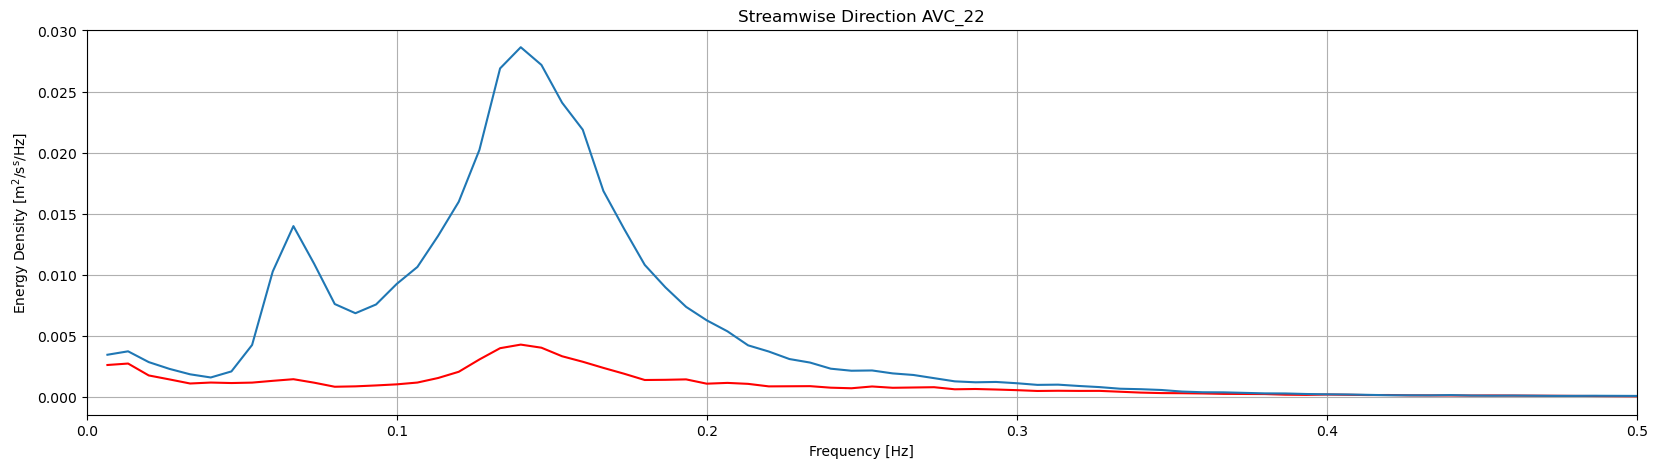

In [38]:
def plot_energy_density(data_binned):
    plt.figure(figsize=(20,5))
    plt.plot(data_binned['freq'], data_binned['psd'].sel(S='Syy').mean(dim='time'), c = 'r')
    plt.plot(data_binned['freq'], data_binned['psd'].sel(S='Sxx').mean(dim='time'))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Energy Density $\mathrm{[m^2/s^s/Hz]}$')
    plt.title('Streamwise Direction %s' %(data_binned.deployment_name))
    plt.xlim(0,0.5)
    plt.grid()

plot_energy_density(ds_binned)

## Plot Streamwise Direction

C:\Users\lachl\AppData\Local\Temp\ipykernel_14492\945069293.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1)


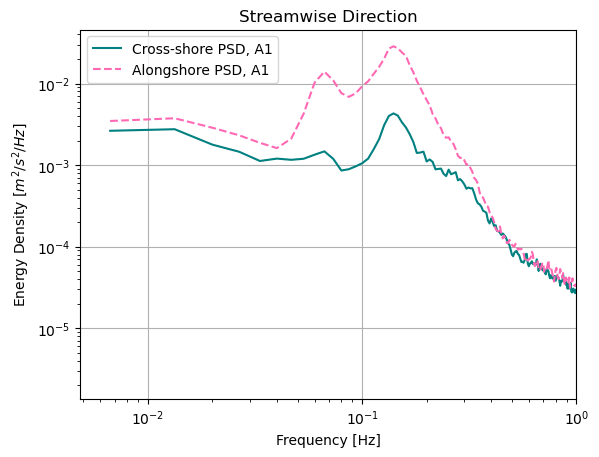

In [40]:
plt.figure()
plt.loglog(ds_binned['freq'], ds_binned['psd'].sel(S='Syy').mean(dim='time'), c='teal', label='Cross-shore PSD, A1')
plt.loglog(ds_binned['freq'], ds_binned['psd'].sel(S='Sxx').mean(dim='time'), c='#FF69B4', ls = '--', label='Alongshore PSD, A1')

plt.xlim(0, 1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Energy Density [$m^2/s^2/Hz$]')
plt.title('Streamwise Direction')
plt.legend()
plt.grid(True)
plt.show()

# Step 7: **Polar Plot Visualisation**

In [45]:
# Convert direction to radians
def radial_plot(ds, instr):
    u = ds.variables["vel"][0]
    v = ds.variables["vel"][1]
    resultant_vector = np.sqrt(u**2 + v**2)
    direction = np.degrees(np.arctan2(v, u))

    direction_rad = np.deg2rad(direction)
    
    
    # Calculate the circular mean
    circular_mean = np.arctan2(np.mean(np.sin(direction_rad)), np.mean(np.cos(direction_rad)))

    # Convert the circular mean back to degrees
    circular_mean_deg = np.rad2deg(circular_mean)
    

    # Create a polar scatter plot
    fig, ax = plt.subplots(figsize = (10,10), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title(f"Flow velocity {instr}", pad=20)
    size =  (2*resultant_vector**2)
    sc = ax.scatter(direction_rad, resultant_vector, c=resultant_vector, s=size, cmap='viridis', vmin=0, vmax=2)

    
    #Convert from -180 to 180 to 0 to 360
    if circular_mean_deg < 0:
        mean_dir_print = circular_mean_deg + 360
    else:
        mean_dir_print = circular_mean_deg
    
    ax.plot([circular_mean, circular_mean], [0, resultant_vector.max()], color='red', linestyle='--', label=f"Mean direction = {(mean_dir_print):.1f} deg")
    ax.legend()

    ax.set_rmax(1.6)
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Flow velocity (m/s)", extend='both', pad=0.1)
    #plt.savefig(f"202310_new_radial_plot_{instr}.png")
    #plt.show()

    
def get_polar_angle(ds):
# Calculate the polar angle (angle in the xy plane)
    ds['polar_angle'] = np.degrees(np.arctan2(ds['vel'][1], ds['vel'][0]))


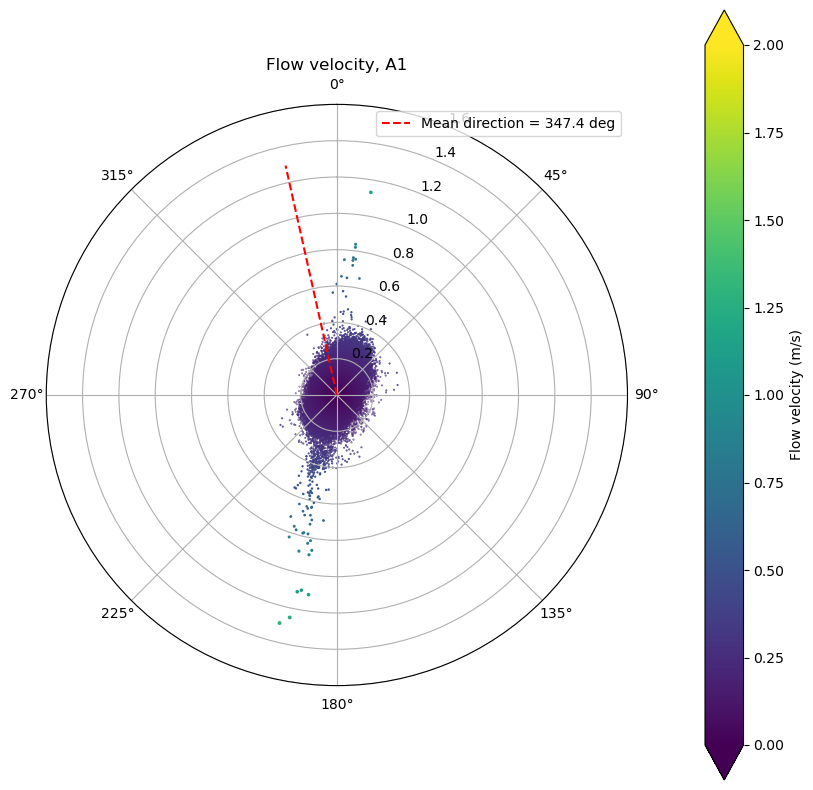

In [47]:
u = ds.variables["vel"][0]
v = ds.variables["vel"][1]

# Calculate the polar angle (angle in the xy plane)
get_polar_angle(ds)

resultant_vector = np.sqrt(u**2 + v**2)


radial_plot(ds, 'A1')
plt.title('Flow velocity, A1')
plt.show()


## Consider tidal phase:

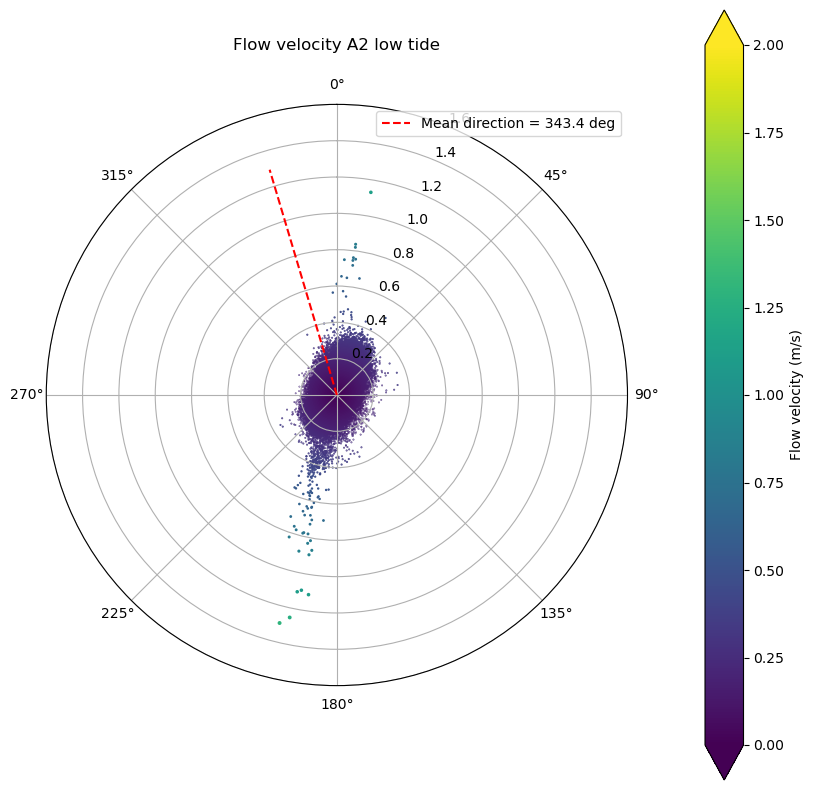

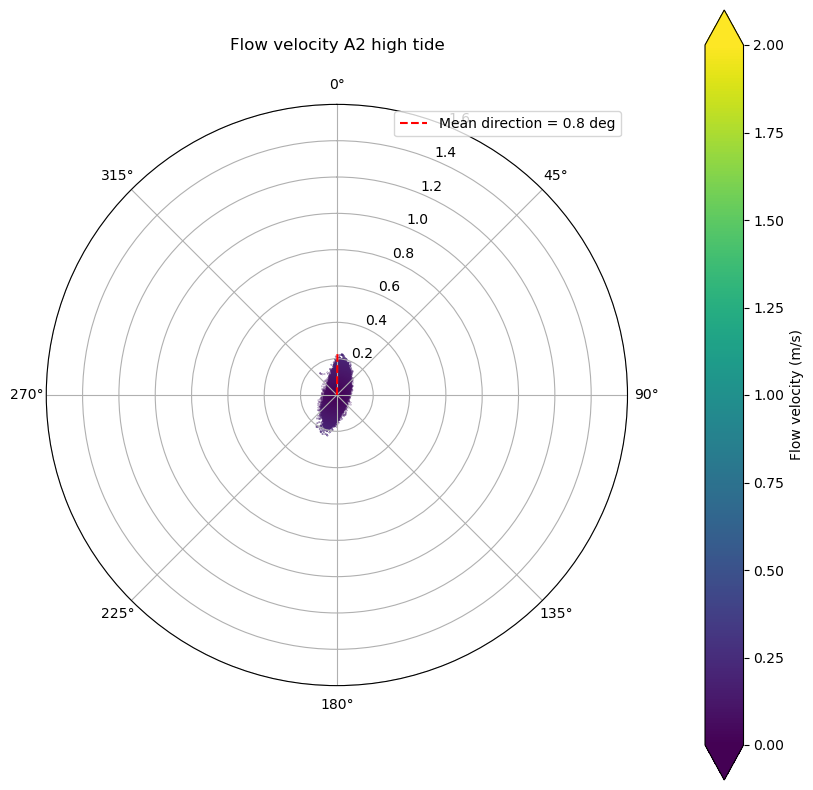

In [50]:
radial_plot(ds_low_tide, 'A2 low tide')
radial_plot(ds_high_tide, 'A2 high tide')

### Plot Radial Histogram

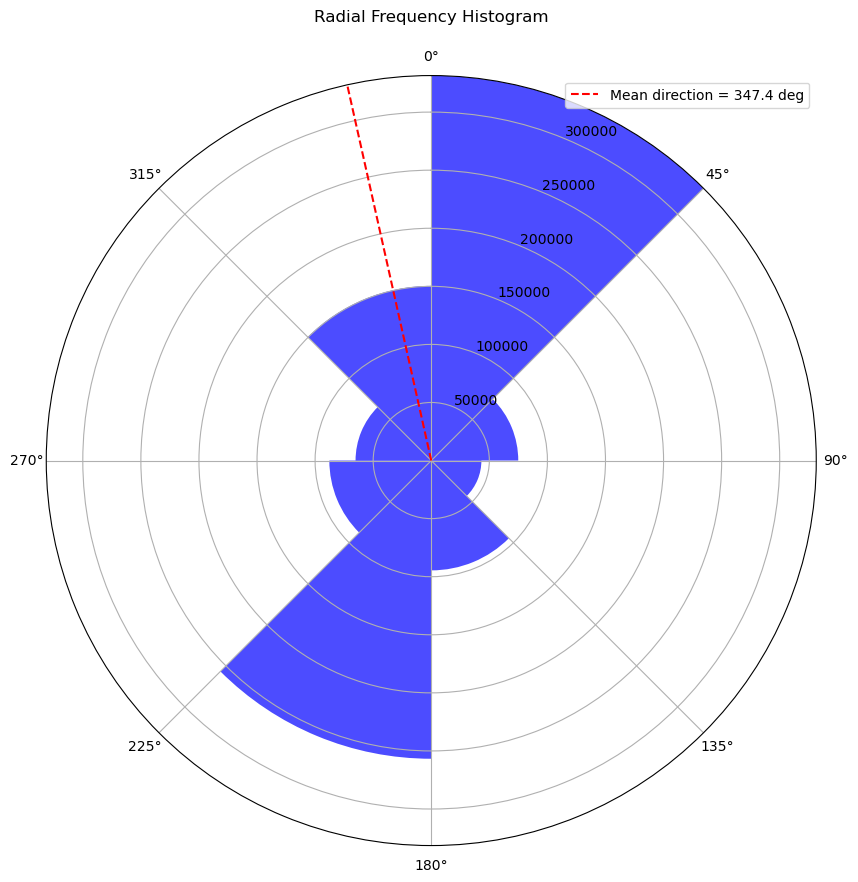

In [88]:

def radial_histogram_plot(ds):
    u = ds.variables["vel"][0]
    v = ds.variables["vel"][1]
    resultant_vector = np.sqrt(u**2 + v**2)
    direction = np.degrees(np.arctan2(v, u))

    direction_rad = np.deg2rad(direction)
    
     # Calculate the circular mean
    circular_mean = np.arctan2(np.mean(np.sin(direction_rad)), np.mean(np.cos(direction_rad)))

    # Convert the circular mean back to degrees
    circular_mean_deg = np.rad2deg(circular_mean)

    # Create a polar histogram plot with 8 bins
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title("Radial Frequency Histogram", pad=20)

    # Calculate histogram in seconds
    sample_rate = 8  # Hz
    time_per_sample = 1 / sample_rate  # seconds per sample
    hist, bin_edges = np.histogram(direction_rad, bins=8)
    hist_seconds = hist / (sample_rate / 8)  # Convert from samples to seconds

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot the histogram bars
    ax.bar(bin_centers, hist_seconds, width=(2 * np.pi / 8), align='center', alpha=0.7, color='blue')


    if circular_mean_deg < 0:
        mean_dir_print = circular_mean_deg + 360
    else:
        mean_dir_print = circular_mean_deg
    
    ax.plot([circular_mean, circular_mean],  [0, np.max(hist_seconds)], color='red', linestyle='--', label=f"Mean direction = {(mean_dir_print):.1f} deg")
    ax.legend()
    
    ax.legend()

    # Set the radius limit
    ax.set_rmax(np.max(hist_seconds) + 2)  # Adding a buffer to the limit

    plt.show()

 
ds_cleaned = ds.dropna(dim='time')
# Call the function with your dataset (ds)
radial_histogram_plot(ds_cleaned)